In [77]:
# generate data
import Distributions
using Random
using Plots

Random.seed!(42)

n_samples = 10
dimensionality = 2
rθ = [-0.9, 0.5]
ms = [[0.9, 0.1], [0.2, 0.8]]
inputs = randn(n_samples, dimensionality)
σ(w, x) = 1/(1+exp(-w'x))
A = [[0.85 0.3; 0.15 0.7], [0.4 0.6; 0.6 0.4]]
s = [[0.8, 0.2]]
for i in 2:n_samples
    push!(s, rand(A)*s[end])
end
πs = [σ(rθ, ms[findmax(s[1])[2]]) for i in 1:n_samples]
outputs = [rand(Distributions.Bernoulli(πs[i])) for i in 1:n_samples];

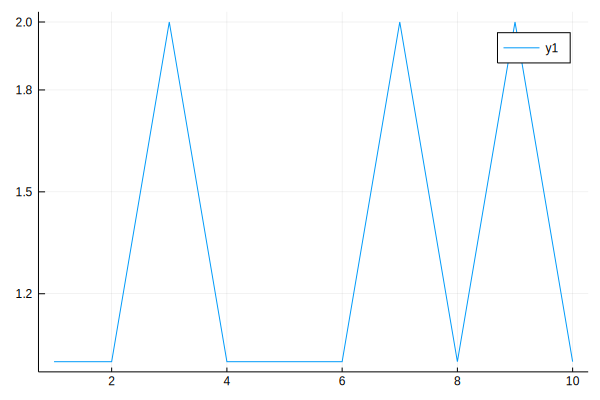

In [78]:
plot([findmax(x)[2] for x in s])

In [79]:
using Turing

In [85]:
logistic(w,x) = 1/(1+exp(-w'x))

@model user_preferences(outputs, σ²; mpriors, D=2) = begin
    
    K = length(mpriors[1])
    n_samples = length(outputs)
    weights   = Vector{Vector}(undef, n_samples)
    
    # State sequence.
    s = tzeros(Int, n_samples)

    m = Vector(undef, K)

    # Transition matrix.
    T = Vector{Vector}(undef, K)
    for i in 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ MvNormal(mpriors[i], 1e-2)
    end
    
    θ ~ MvNormal(zeros(D), sqrt(σ²)) 
    
    s[1] ~ Categorical(K)
    weights[1] ~ MvNormal(m[s[1]], 1e-4)
    
    for i in 2:n_samples
        s[i] ~ Categorical(vec(T[s[i-1]]))
        weights[i] ~ MvNormal(m[s[i]], sqrt(10.0))
#         @show weights
    end

    for i in 1:n_samples
        π = logistic(weights[i], θ)
        outputs[i] ~ Bernoulli(π)
    end
end;

In [86]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 100
ϵ = 0.05
τ = 10
chains = sample(user_preferences(outputs, 0.1, mpriors=ms), Gibbs(HMC(0.05, 10, :weights, :θ), PG(20, :s)), iterations)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/apodusenko/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/apodusenko/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   2%|▉                                        |  ETA: 0:00:53┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/apodusenko/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/apodusenko/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current pr

Chains MCMC chain (100×41×1 Array{Float64, 3}):

Iterations        = 1:100
Thinning interval = 1
Number of chains  = 1
Samples per chain = 100
Wall duration     = 9.32 seconds
Compute duration  = 9.32 seconds
parameters        = weights[10][1], T[1][2], T[2][1], s[2], s[4], s[9], T[1][1], weights[3][1], T[2][2], s[1], s[6], weights[4][1], weights[6][2], weights[1][1], θ[2], θ[1], m[2][1], weights[1][2], s[8], weights[6][1], weights[7][2], s[7], weights[4][2], weights[2][1], s[10], weights[7][1], s[3], m[1][2], weights[5][1], weights[8][2], weights[9][1], weights[10][2], s[5], m[2][2], weights[3][2], weights[2][2], m[1][1], weights[9][2], weights[8][1], weights[5][2]
internals         = lp

Summary Statistics
     parameters      mean       std   naive_se      mcse        ess      rhat  ⋯
         Symbol   Float64   Float64    Float64   Missing    Float64   Float64  ⋯

        T[1][1]    0.6765    0.0000     0.0000   missing        NaN       NaN  ⋯
        T[1][2]    0.3235    0.0000   

In [87]:
d = 2

sumstats = summarize(chains, mean, std)
mθ, vθ   = sumstats.nt.mean[1:2], sumstats.nt.std[1:2]
mw       = [sumstats.nt.mean[i:i+d-1] for i in d+1:d:d*n_samples+d]

10-element Vector{Vector{Float64}}:
 [0.785979054295272, 0.21402094570472777]
 [0.8979039538467617, 0.09492537742160388]
 [0.19157999970879197, 0.7864170000647703]
 [-0.6265595574833271, 0.6372249159397486]
 [1.0, 1.08]
 [1.79, 1.03]
 [1.01, 1.96]
 [1.01, 1.06]
 [1.09, 1.08]
 [0.8980241077132084, 0.09489067376693747]

In [144]:
e_outputs = round.([logistic(mθ, mw[i]) for i in 1:n_samples])

100-element Vector{Float64}:
 1.0
 1.0
 0.0
 0.0
 0.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 1.0
 0.0
 ⋮
 0.0
 1.0
 0.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 1.0
 1.0
 1.0

In [145]:
sum(outputs .== e_outputs)

81